# 1.3 mln t-SNE

http://cf.10xgenomics.com/supp/cell-exp/megacell_tutorial.html

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

sns_styleset()

In [3]:
# Scanpy colors (originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)
clusterCols = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"][:60]
clusterCols = np.array(clusterCols)

# Load the results processed on the server

X = pickle.load(open('big-pickles/10x-pca.pickle', 'rb')).astype(float)

Z25k, position_id = pickle.load(open("big-pickles/10x-downsampling.pickle", "rb"))
np.random.seed(42)
ind25k  = np.random.choice(X.shape[0], 25000, replace=False)

Zs, clustersScanpy = pickle.load(open("big-pickles/10x-tsne.pickle", "rb"))
print(list(Zs.keys()))

# To make it look like a fish :-)
# Only for PCA-based initialisations
Z25k = -Z25k[:,::-1]
for key in ['pcainit', 'noexagg', 'noexagg-pcainit', 'mine']:
    Zs[key] = -Zs[key][:,::-1]

[markergenes, markerexp] = pickle.load(open("million-pickles/markers.pickle", "rb"))

print('')
print(np.sort(markergenes))

['pcainit', 'belkina', 'randinit', 'noexagg', 'default', 'noexagg-pcainit', 'mine', 'scanpy', 'umap']

['Acsbg1' 'Akap7' 'Aldoc' 'Aqp4' 'Bgn' 'Ctss' 'Eomes' 'Flt1' 'Foxp2'
 'Gad1' 'Gad2' 'Gja1' 'Gjb6' 'Hes1' 'Htr3a' 'Itgam' 'Itgam' 'Lcat' 'Meg3'
 'Mog' 'Myl9' 'Neurod6' 'Nrn1' 'Nrp1' 'Olig1' 'Pax6' 'Pdgfra' 'Pvalb'
 'Reln' 'S1pr1' 'Slc17a6' 'Slc17a7' 'Slc1a3' 'Slc32a1' 'Snap25' 'Sox2'
 'Sst' 'Stmn2' 'Tac1' 'Tac2' 'Tbr1' 'Top2a' 'Tubb3' 'Vip' 'Xdh']


In [14]:
def mlnplot(Z, subset=None, size=6, alpha=1, showmeans=True, omit_means=None, ticks=False):
    
    if subset is None:
        subset = np.arange(Z.shape[0])
        
    if size is not None:
        plt.figure(figsize=(size,size))
    
    np.random.seed(42)
    ind = np.random.permutation(Z.shape[0])
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(Z[:,0][ind], Z[:,1][ind], s=1, c=clusterCols[clustersScanpy][subset][ind], 
                alpha=alpha, rasterized=True, edgecolor='none')
    
    K = np.max(clustersScanpy)+1
    Zmeans = np.zeros((K, 2))
    for c in range(K):
        if np.any(np.isnan(Z[clustersScanpy[subset]==c,0])):
            Zmeans[c,:] = np.nan
        else:
            Zmeans[c,:] = np.median(Z[clustersScanpy[subset]==c,:2], axis=0)
            
    if omit_means is None:
        means_to_show = np.arange(K)
    else:
        means_to_show = np.array([c for c in np.arange(K) if c not in omit_means])
            
    if showmeans:
        plt.scatter(Zmeans[means_to_show,0], Zmeans[means_to_show,1], 
                    color=clusterCols[means_to_show],
                    s=100, edgecolor='k', linewidth=.6);
    
        for c in means_to_show:
            if c in [12,21,37,32,35,9,15,18]:
                col = 'w'
            else:
                col = 'k'
            plt.text(Zmeans[c,0], Zmeans[c,1], str(c), fontsize=6, 
                     color=col, ha='center', va='center')
    
    if not ticks:
        plt.xticks([])
        plt.yticks([])
    if size is not None:
        plt.tight_layout()

In [9]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn_classes=10, subsetsize=1000, seed=42):
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    np.random.seed(seed)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn_global, rho)

metrics = {}
for key in Zs.keys():
    metrics[key] = embedding_quality(X, Zs[key], clustersScanpy)

<IPython.core.display.Javascript object>


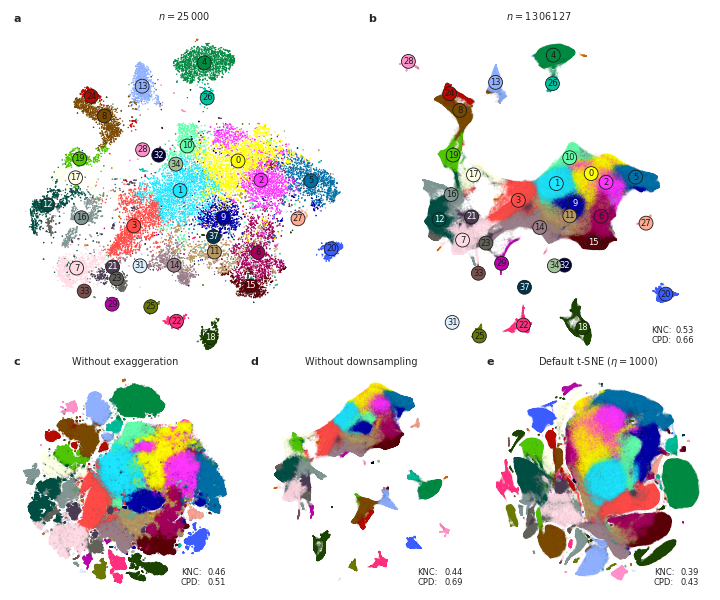

In [34]:
plt.figure(figsize=(7.2, 6))
ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=3)
mlnplot(Z25k, subset=ind25k, size=None, omit_means=[30, 35, 36, 38])
plt.title(r'$n=25\,000$')
plt.tight_layout()

ax2 = plt.subplot2grid((5, 6), (0, 3), colspan=3, rowspan=3)
mlnplot(Zs['mine'], size=None, omit_means=[30, 35, 36, 38], alpha=.1)
plt.title(r'$n=1\,306\,127$')
plt.text(0.83,.05,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.90,.05,'{:.2f}\n{:.2f}'.format(*metrics['mine']), transform=plt.gca().transAxes, fontsize=6)

ax3 = plt.subplot2grid((5, 6), (3, 0), rowspan=2, colspan=2)
mlnplot(Zs['noexagg'], size=None, showmeans=False, alpha=.1)
plt.title('Without exaggeration')
plt.text(0.75,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics['noexagg']), transform=plt.gca().transAxes, fontsize=6)

ax4 = plt.subplot2grid((5, 6), (3, 2), rowspan=2, colspan=2)
mlnplot(Zs['pcainit'], size=None, showmeans=False, alpha=.1)
plt.title('Without downsampling')
plt.text(0.75,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics['pcainit']), transform=plt.gca().transAxes, fontsize=6)

ax5 = plt.subplot2grid((5, 6), (3, 4), rowspan=2, colspan=2)
mlnplot(Zs['scanpy'], size=None, showmeans=False, alpha=.1)
plt.title('Default t-SNE (' r'$\eta=1000$' ')')
plt.text(0.75,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics['scanpy']), transform=plt.gca().transAxes, fontsize=6)

sns.despine(left=True, bottom=True)
plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.04, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.04, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.04, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=8, fontweight='bold')

plt.savefig('figures/mln.png', dpi=150)
plt.savefig('figures/mln.pdf', dpi=300)
plt.savefig('figures/mln-600.pdf', dpi=600)

<IPython.core.display.Javascript object>


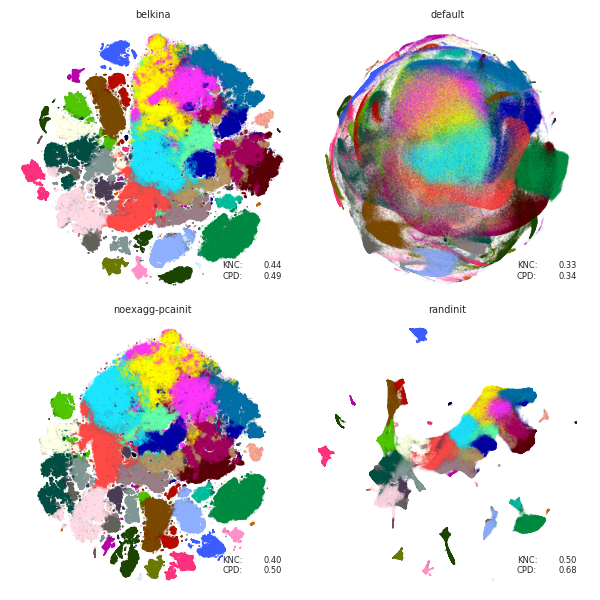

In [35]:
# Some other options

plt.figure(figsize=(6, 6))

for i,key in enumerate(['belkina', 'default', 'noexagg-pcainit', 'randinit']):
    plt.subplot(2,2,i+1)
    mlnplot(Zs[key], size=None, showmeans=False, alpha=.1)
    plt.title(key)
    plt.text(0.75,.05,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.90,.05,'{:.2f}\n{:.2f}'.format(*metrics[key]), transform=plt.gca().transAxes, fontsize=6)    

sns.despine(left=True, bottom=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


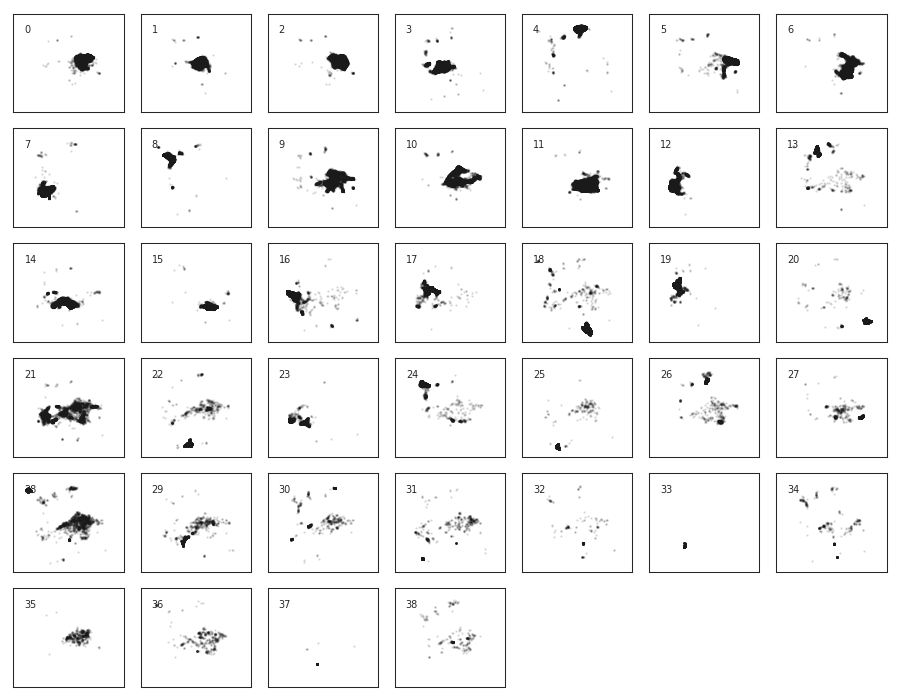

In [32]:
# Which cluster means to hide from the main figure (because they are not "clustered")

plt.figure(figsize=(9,7))
for i in range(39):
    plt.subplot(6,7,i+1)
    plt.scatter(Zs['mine'][clustersScanpy==i,0], Zs['mine'][clustersScanpy==i,1], color='k', s=1, alpha=.1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-30,30])
    plt.ylim([-30,30])
    plt.text(.1, .8, str(i), transform = plt.gca().transAxes)
plt.tight_layout()

In [3]:
# MARKER GENES

# From Tasic 2016: Aqp4 (astrocytes); Pdgfra (oligodendrocyte precursor cells, OPCs); Mog (oligodendrocytes); 
# Itgam (microglia); Flt1 (endothelial cells); and Bgn (smooth muscle cells, SMC)

# Non-neuronal cells. We identify astrocytes based on expression of previously reported 
# markers Aqp4, F3, and Gfap12. Our Oligo-96*Rik type corresponds to previously described 
# newly generated oligodendrocytes based on the unique expression of Enpp6 and 9630013A20Rik 
# (abbreviated as 96*Rik), while our Oligo-Opalin type corresponds to myelinating oligodendrocytes13.
# Oligo precursor cells (OPC) express Pdgfra and Cspg4 as previously reported12,13. Accordingly,
# microglial cells express Itgam, Cx3cr1 and C1qb13. We identify endothelial cells based on 
# expression of Flt1 (ref. 13), and smooth muscle cells (SMC) based on the expression of Bgn

# From Allen Data RNAseq whitepaper: 'Olig1', 'Gja1', 'Xdh', 'Ctss', 'Myl9'

# From https://www.biorxiv.org/content/biorxiv/early/2017/10/03/197244.full.pdf
# Tubb23 - neurons, Slc1a3 - radial glia, Top2a - dividing cells, Stmn2 - neurons
# Meg3 - interneurons and CR, Nrp1 - glutamat, Gad2 - interneurons,
# Tac2 - neuroblasts, Reln - CR, Pax6 - glia, Tbr2 - neural progenitors,
# Tbr1 - post-mitotic neurons
#
# Englung: Pax6 (radial glia) -> Eomes (aka Tbr2) (committed progenitors) -> Tbr1 (pyramidal neurons)

# Add from http://www.sequmed.com/Private/Files/20170726/6363668905396462451645665.pdf
# Stmn2 - pan neuronal
# Tbr1 - excitatory
# Gad1 - inhibitory
# Hes1 - glia
# Aldoc - astrocyte - this is wrong, Aldoc is a strong radial glia marker
# Oligo1 - oligodendrocytes

<IPython.core.display.Javascript object>


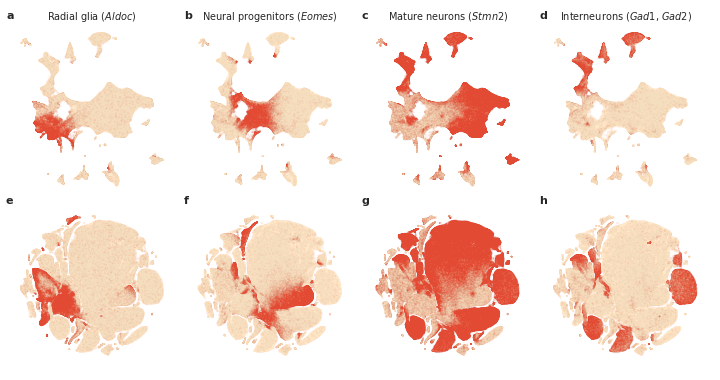

In [36]:
# Slc1a3 similar to Aldoc but goes more into Eomes
# Tubb3 similar to Stmn2 but also goes more into Eomes

markers = [['Aldoc'], ['Eomes'], ['Stmn2'], ['Gad1', 'Gad2']]

titles = ['Radial glia\n' + r'$\mathit{Aldoc}$',
          'Neural progenitors\n' + r'$\mathit{Eomes}$',
          'Mature neurons\n' + r'$\mathit{Stmn2}$',
          'Interneurons\n' + r'$\mathit{Gad1}$ or $\mathit{Gad2}$']

titles = [r'Radial glia ($\mathit{Aldoc}$)',
          r'Neural progenitors ($\mathit{Eomes}$)',
          r'Mature neurons ($\mathit{Stmn2}$)',
          r'Interneurons ($\mathit{Gad1}$, $\mathit{Gad2}$)']

plt.figure(figsize=(7.2, 3.8))

for i,genes in enumerate(markers):
    detected = np.sum(markerexp[:, np.isin(markergenes, genes)], axis=1) > 0
    colors = ['#e34a33' if c else '#fee8c8' for c in detected]
    
    plt.subplot(2, len(markers), i+1)
    plt.gca().set_aspect('equal')
    plt.scatter(Zs['mine'][:,0], Zs['mine'][:,1], s=1, c=colors, alpha=.1, 
                rasterized=True, edgecolor='none')
    plt.title(titles[i], va='center')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, len(markers), i+1+4)
    plt.gca().set_aspect('equal')
    plt.scatter(Zs['scanpy'][:,0], Zs['scanpy'][:,1], s=1, c=colors, alpha=.1, 
                rasterized=True, edgecolor='none')
    plt.xticks([])
    plt.yticks([])

sns.despine(left=True, bottom=True)
plt.tight_layout()

letters = 'aebfcgdh'
for i,l in enumerate(letters):
    plt.text(-0.05, 1.035, l, transform = plt.gcf().get_axes()[i].transAxes, fontsize=8, fontweight='bold')

plt.savefig('figures/mln-markers.png', dpi=150)
plt.savefig('figures/mln-markers.pdf', dpi=300)
plt.savefig('figures/mln-markers-600.pdf', dpi=600)

<IPython.core.display.Javascript object>


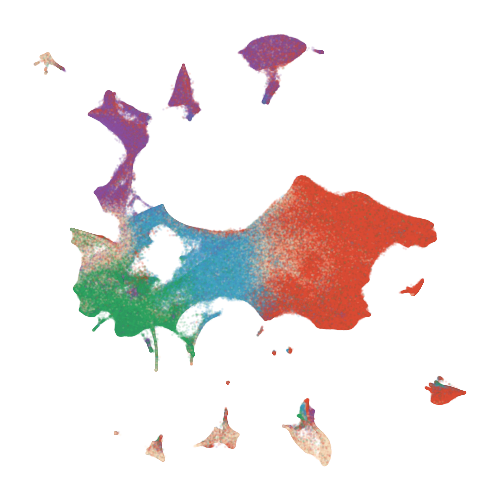

In [20]:
# Alternative way to show developmental transitions

sns.set_style('white')
plt.figure(figsize=(5,5))

types = (np.sum(markerexp[:, np.isin(markergenes, ['Stmn2'])], axis=1) > 0).astype(int)
types[np.sum(markerexp[:, np.isin(markergenes, ['Eomes'])], axis=1) > 0] = 2
types[np.sum(markerexp[:, np.isin(markergenes, ['Aldoc'])], axis=1) > 0] = 3
types[np.sum(markerexp[:, np.isin(markergenes, ['Gad1','Gad2'])], axis=1) > 0] = 4

colors = np.array(['#fee8c8', '#e34a33', '#43a2ca', '#2ca25f', '#8856a7'])
np.random.seed(42)
randorder = np.random.permutation(X.shape[0])
plt.scatter(Zs['mine'][:,0][randorder], Zs['mine'][:,1][randorder], 
            s=1, c=colors[types][randorder], alpha=.1, rasterized=True)

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


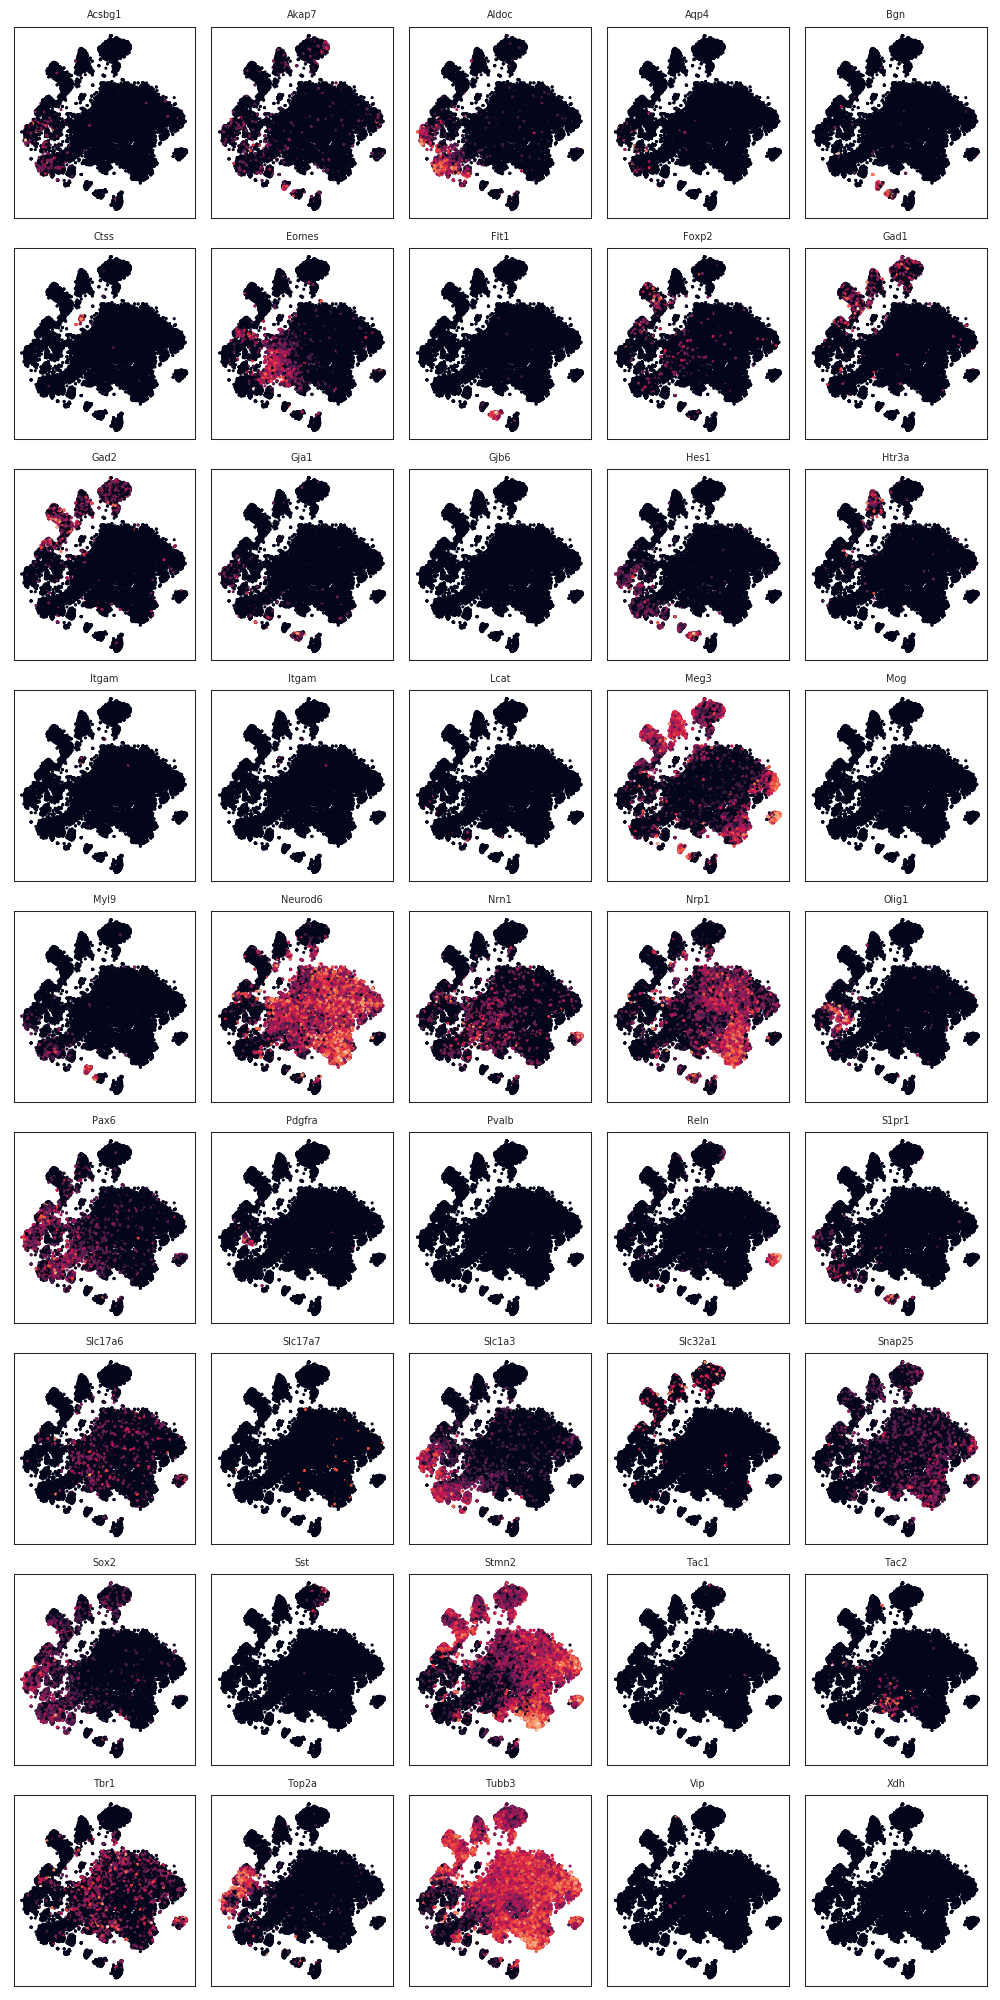

In [22]:
plt.figure(figsize=(10,20))

for i,gene in enumerate(np.sort(markergenes)):
    plt.subplot(9,5,i+1)
    plt.scatter(Z25k[:,0], Z25k[:,1], s=2, 
                c=np.log2(1+np.sum(markerexp[:,markergenes==gene][ind25k,:],axis=1)))
    plt.title(gene)
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

## UMAP

<IPython.core.display.Javascript object>


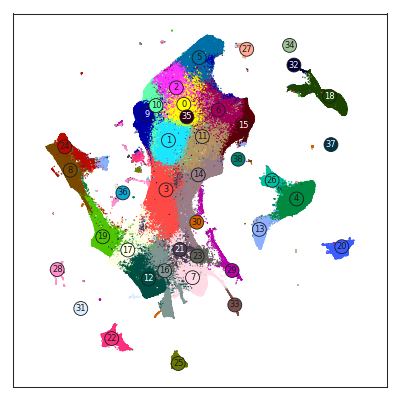

In [30]:
mlnplot(Zs['umap'], size=4)